This is the final project for the machine learning course. Enron financial data and email data will be investigated to find the list of person of interest (POI) who was involved in the fraud activities.

Below is the order of the investigation process I will employ for this final project.
- Univariate analysis to process the dataset (taking care of missing values and outliers)
- Bivariate analysis to find features that can be dimensionally reduced through PCA
- Try a variety of classfiers

First, necessary Libraries will be loaded.

In [31]:
#!/usr/bin/python

import sys
import pickle
import pprint
import matplotlib.pyplot as plt
import numpy as np

### Setting the path
sys.path.append("../tools/")

### These are the scripts given in the class
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

Load the dictionary containing the dataset.

In [32]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [33]:
len(data_dict)

146

There are total 146 number of data in data_dict. I am going to print out the first two of the data from data_dict to see how the dictionary looks like.

In [34]:
stop = 0
for k, v in data_dict.iteritems():
    print k
    pprint.pprint(v)
    if stop == 1:
        break
    stop += 1

METTS MARK
{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}
BAXTER JOHN C
{'bonus': 1200000,
 'deferral_payments': 1295738,
 'deferred_income': -1386055,
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 6680544,
 'expenses': 11200,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 1586055,
 'other': 2660303,
 'poi': False,
 'restricted_stock': 3942714,
 'rest

The keys of data_dict are the names of people and the values are various features. Every feature except poi and email_address are numerical values. It looks like it is either a number of 'NaN' when the data is missing. And poi is a boolean value that I can use to find POI's.

In [35]:
### Finding the number of features
for k,v in data_dict.iteritems():
    print "The number of features:", len(v)
    features_list = v.keys() # features are saved separately for later use
    break

The number of features: 21


There are total 21 features in the dataset. I will ignore "email_address" because they are not numerical values. And I will ingore 'other' as well because I don't know what this is.

In [36]:
### Removing poi and email_address
try:
    features_list.remove("email_address")
    features_list.remove("other")
except:
    pass

### Convert data_dict into numpy array
data = featureFormat(data_dict, features_list)
print "The type of data:", type(data)
print "The total number of data", data.shape

The type of data: <type 'numpy.ndarray'>
The total number of data (145L, 19L)


Now the data_dict is converted to numpy array. And it contains 145 rows and 19 columns. 
featureFormat ignores the "NaN" values and creates numpy array that I can use it for the analysis more easily.

Using data numpy array I will check the number of poi's and non-poi's.

In [37]:
### Finding the index of poi
poi_ind = features_list.index("poi")

### Print out the number of poi and non-poi
print "The total number of poi:", np.sum(data[:,poi_ind])
print "The total number of non-poi:", np.size(data[:,poi_ind]) - np.sum(data[:,poi_ind])

The total number of poi: 18.0
The total number of non-poi: 127.0


There are total 18 POI and 127 non-POI.

In [38]:
### Move poi column to the end
### data
tmp_data = data
tmp_data[:,-1] = data[:,poi_ind]
tmp_data[:,poi_ind] = data[:,-1]
data = tmp_data

### features_list
tmp = features_list[-1]
features_list[poi_ind] = tmp
features_list[-1] = "poi"

### Reassign poi index
poi_ind = features_list.index("poi")

I moved poi column to the end to use the data more easily.

## Plotting

From now on, I will start drawing various plots for univariate analysis and bivariate analysis.
I will draw histograms for each feature first.

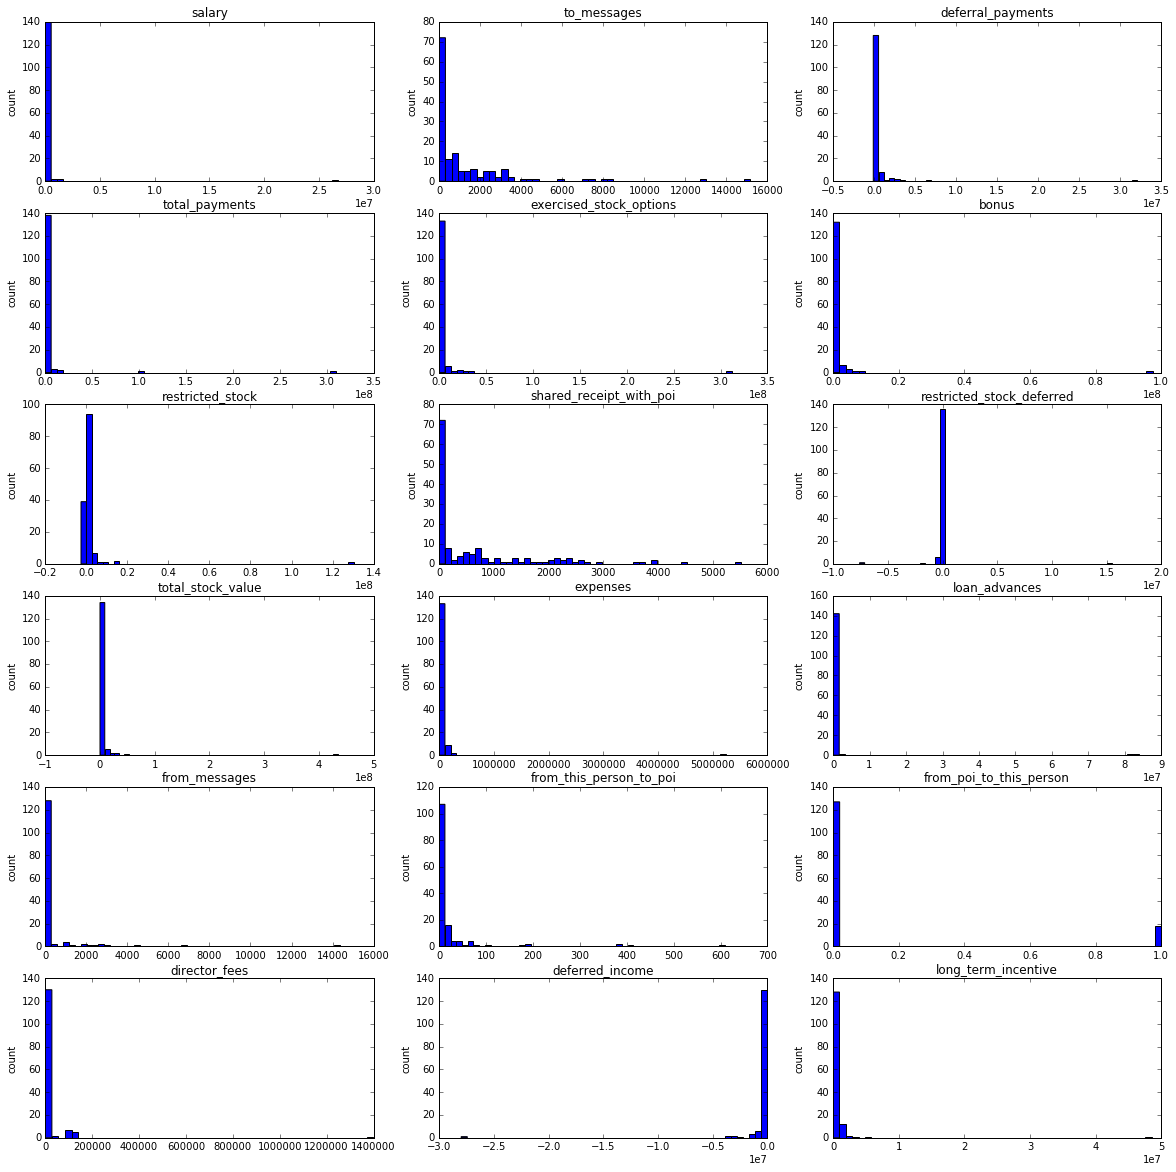

In [39]:
### Create new features list without poi
features_list_new = [ii for ii in features_list if ii != "poi"]

%matplotlib inline
### 20 histograms for features
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(6, 3)

### the histogram of the data
### x: x coordinate values, y: y coordinate values
### r: row index, c: column index
### title: title of a subplot
def subplot_histogram(x, bins, r, c, title):
    axarr[r, c].hist(x, bins = bins)
    axarr[r, c].set_title(title)
    axarr[r, c].set_ylabel("count")

for i in range(len(features_list_new)):
    subplot_histogram(data[:,i],50,i/3,i%3,features_list_new[i])

plt.show()

Above diagrams show 19 histograms. I first created new list of features excluding poi because array of poi consists of only true or false so it won't provide an insightful histogram. 

Looking at these histograms, I can see there are outliers for every feature.

I will look into salary more deeply and see if there is any interesting thing going on.

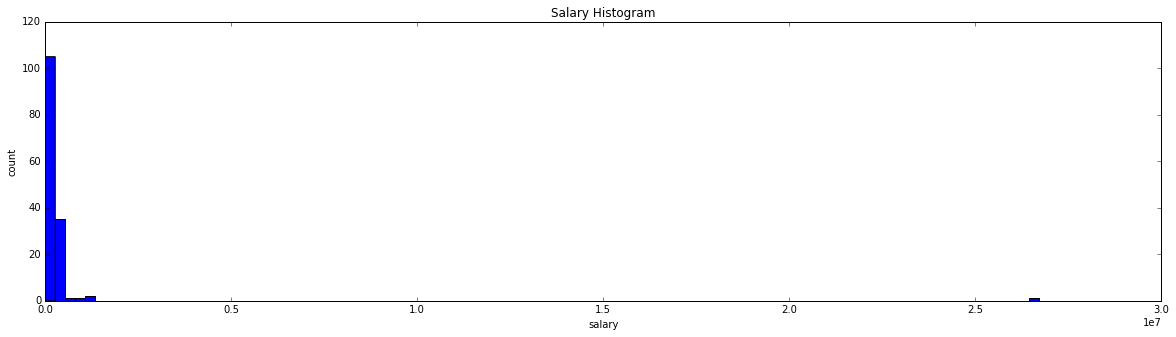

In [40]:
%matplotlib inline
### Find indices for salary
salary_ind = features_list.index("salary")

### Set the size of the plot
plt.rcParams["figure.figsize"] = (20,5)

### Draw Salary histogram
plt.hist(data[:,salary_ind], bins=100)
plt.xlabel("salary")
plt.ylabel("count")
plt.title("Salary Histogram")
plt.show()

Now I will get rid of the outlier above 2.5e7 and replot the histogram

53408458.0 is the total sum of salaries
26704229.0 is removed


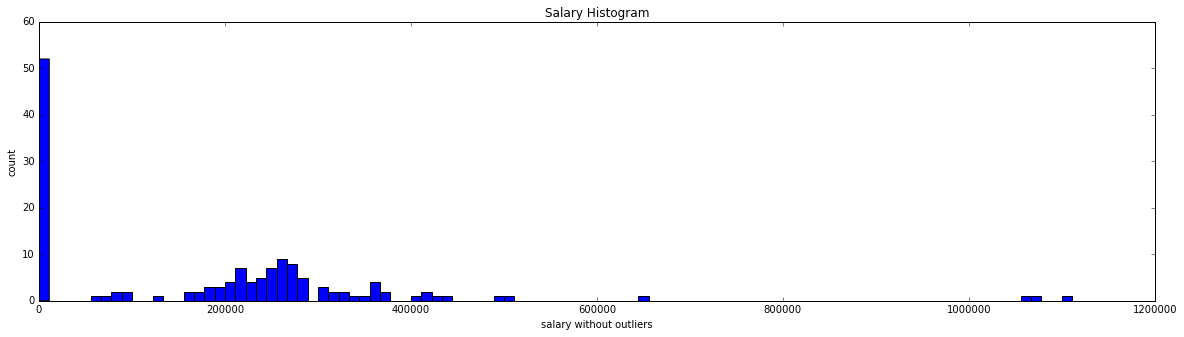

In [41]:
### Total sum of salaries
import numpy as np
print np.sum(data[:,salary_ind]), "is the total sum of salaries"

### Create new array that contains salar values without outliers
salary_no_outliers = []
for i in data[:,salary_ind]:
    if i < 2.5e7:
        salary_no_outliers.append(i)
    else:
        print i, "is removed"

### Draw Salary histogram
plt.hist(salary_no_outliers, bins=100)
plt.xlabel("salary without outliers")
plt.ylabel("count")
plt.title("Salary Histogram")
plt.show()

The outlier removed is half of the total sum of salary array, which means someone added a total sum of salaries into the data. I believe that in data_dict there is a key that contains the sum of every feature.

In [42]:
for k,v in data_dict.iteritems():
    if v["salary"] == 26704229.0:
        print k,v

TOTAL {'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}


As I expected one of the keys in data_dict is TOTAL. I will create a new dictionary that excludes this key.

In [43]:
### New data_dict excluding TOTAL key
data_dict_new = {}

for k, v in data_dict.iteritems():
    if k != "TOTAL":
        data_dict_new[k] = v

### Print out the new data_dict length
print "The length of the new data_dict:", len(data_dict_new)
    

The length of the new data_dict: 145


Now there are 145 data in the data_dict_new. I will graph the histograms again.

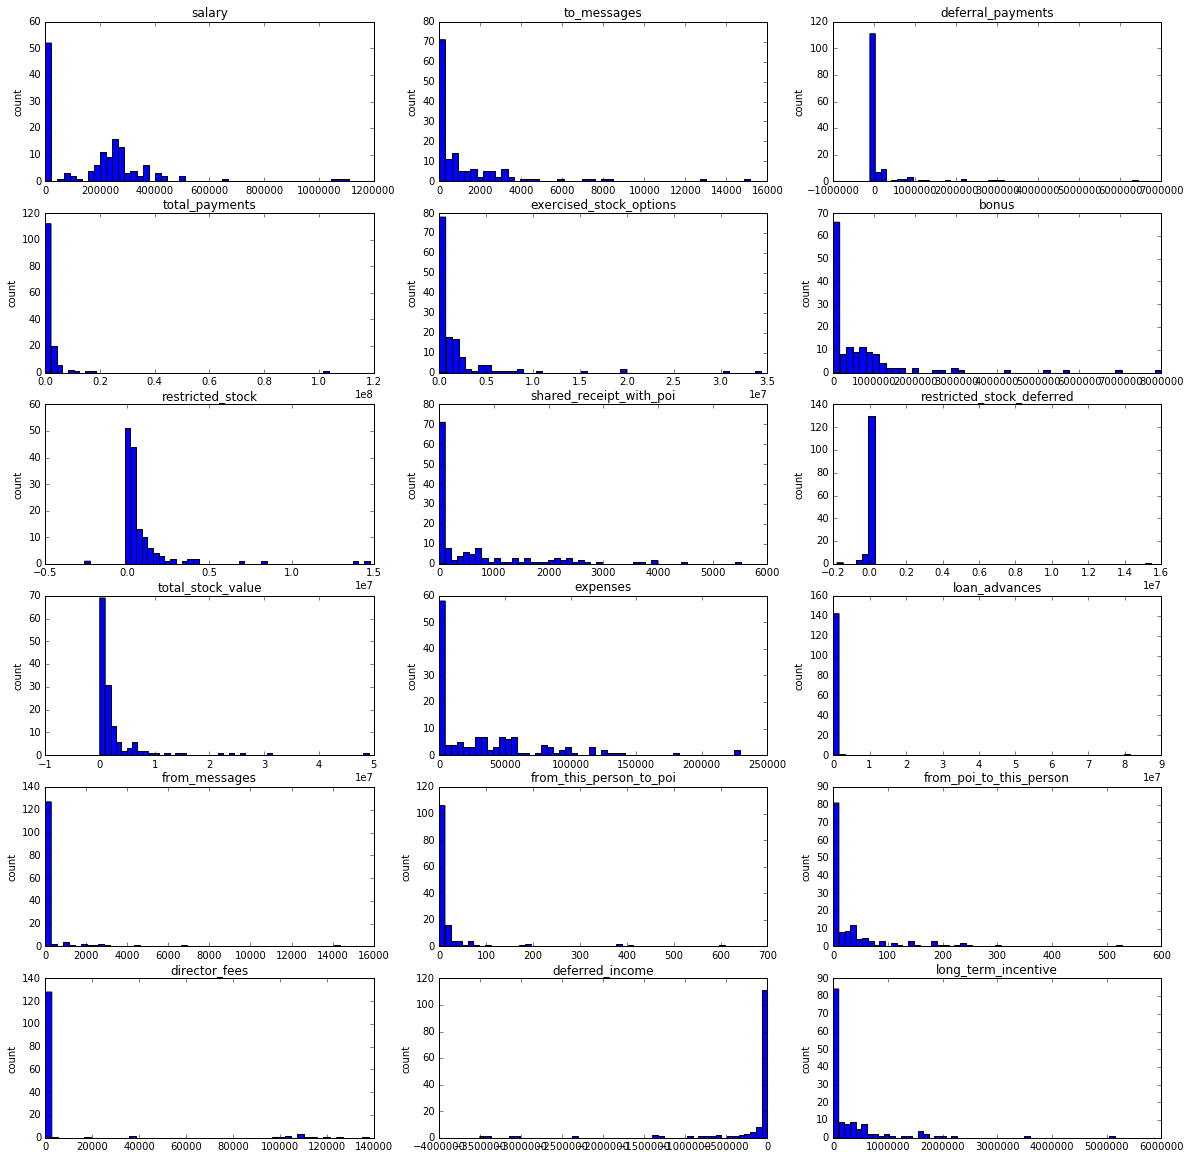

In [44]:
### Convert data_dict_new into numpy array
data = featureFormat(data_dict_new, features_list)

%matplotlib inline
### 20 histograms for features
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(6, 3)

### the histogram of the data
### x: x coordinate values, y: y coordinate values
### r: row index, c: column index
### title: title of a subplot
def subplot_histogram(x, bins, r, c, title):
    axarr[r, c].hist(x, bins = bins)
    axarr[r, c].set_title(title)
    axarr[r, c].set_ylabel("count")

for i in range(len(features_list_new)):
    subplot_histogram(data[:,i],50,i/3,i%3,features_list_new[i])

plt.show()

The histograms are much better than before. Although there are still outliers in histograms, getting rid of them might not be a good idea because those values may be helpful identifying POI's.

I suspect that some of these features will have too many zeros because featureFormat function convert NaN to zero in some cases. I will print out the number of zeros for each feature. 

In [45]:
### defining function that counts zeros
def counting_zeros(data, features_list, feature):
    total_count = 0
    count = 0
    feature_data = data[:,features_list.index(feature)]
    for i in feature_data:
        total_count += 1
        if i == 0:
            count += 1
    print "{}: {}, {}%".format(feature,count, int(float(count)*100/float(total_count)))

### Printing out the number of zeros for each feature
for i in features_list[:-1]:
    counting_zeros(data, features_list, i)

salary: 50, 34%
to_messages: 58, 40%
deferral_payments: 106, 73%
total_payments: 20, 13%
exercised_stock_options: 43, 29%
bonus: 63, 43%
restricted_stock: 35, 24%
shared_receipt_with_poi: 58, 40%
restricted_stock_deferred: 127, 88%
total_stock_value: 19, 13%
expenses: 50, 34%
loan_advances: 141, 97%
from_messages: 58, 40%
from_this_person_to_poi: 78, 54%
from_poi_to_this_person: 70, 48%
director_fees: 128, 88%
deferred_income: 96, 66%
long_term_incentive: 79, 54%


I will ignore features with more than 60% of zeros from now on.

### Features that will be ignored:
- deferral_payments
- restricted_stock_deferred
- loan_advances
- director_fees
- deferred_income

I will recreate data numpy array and features_list array that exclude the features above.

In [46]:
### Save the original features_list before change
features_list_original = features_list

### list of features with too many zeros
too_many_zeros = ["deferral_payments", 
                  "restricted_stock_deferred",
                  "loan_advances",
                  "director_fees",
                  "deferred_income"]

### remove the above features from features_list
for i in too_many_zeros:
    if i in features_list:
        features_list.remove(i)
        
### Convert data_dict_new into numpy array
data = featureFormat(data_dict_new, features_list)
print data.shape

(144L, 14L)


Now the number of columns of data is reduced to 14.

### Checking Scores

Now I am going to test each feature using GaussianNB and check the accuracy, precision and recall. Then I will use features with high values for later use.

I will employ tester functions from tester.

In [47]:
### Import functions from tester_edited.py
from tester_edited import load_classifier_and_data, test_classifier
from sklearn.cross_validation import StratifiedShuffleSplit

This will be a repetitive process so I will create a function to do this.

In [48]:
### the code is from "poi_id.py" from final_project folder.
### this function will split the data into test and train
### apply classifier and calculate the accuracy, precision and recall
def test(features_list,clf):
    ### Store to my_dataset for easy export below.
    my_dataset = data_dict
    
    ### Extract features and labels from dataset for local testing
    data = featureFormat(my_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    
    ### Split train and test by 30 %
    from sklearn.cross_validation import train_test_split
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
    dump_classifier_and_data(clf, my_dataset, features_list)
    
    ### Print out the result
    clf, dataset, feature_list = load_classifier_and_data()
    scores = test_classifier(clf, dataset, feature_list)
    return scores

def classify_simple(features_list):
    print "Features list:", features_list[1:]
    
    ### import GaussianNB
    from sklearn.naive_bayes import GaussianNB
    clf_NB = GaussianNB()

    ### import Decision Tree
    from sklearn import tree
    clf_tree = tree.DecisionTreeClassifier()
    
    ### Call test function and print out test
    scores_NB = test(features_list,clf_NB)
    tree_NB = test(features_list,clf_tree)
    return [ scores_NB, tree_NB ]

### Always put poi at the zeroth index
classify_simple(["poi", "salary"])

Features list: ['salary']
GaussianNB()
	Accuracy: 0.25560	Precision: 0.18481	Recall: 0.79800

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.69210	Precision: 0.23619	Recall: 0.24150



[[0.2556, 0.18480778138026865, 0.798], [0.6921, 0.23618581907090463, 0.2415]]

I created a function that can show the accuracy, precision and recall values from features list input. The purpose is not to get the largest scores but to select features that show the high scores compared to the others. So I didn't specify any parameters for now. The parameters will be adjusted at a later section.

I will use this function for all the other features.

In [49]:
### Iterate over the features_list
scores_list = {}
for i in features_list[:-1]:
    scores_list[i] = classify_simple(["poi", i])

Features list: ['salary']
GaussianNB()
	Accuracy: 0.25560	Precision: 0.18481	Recall: 0.79800

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.69210	Precision: 0.23619	Recall: 0.24150

Features list: ['to_messages']
Got a divide by zero when trying out: GaussianNB()
Precision or recall may be undefined due to a lack of true positive predicitons.
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.73711	Precision: 0.08556	Recall: 0.14100

Features list: ['total_payments']
GaussianNB()
	Accuracy: 0.76308	Precision: 0.06938	

In [50]:
### Print out scores of each feature
print "      Accuarcy Precision Recall"
for k,v in scores_list.iteritems():
    print k
    if v[0] == None:
        print "NB     ---------None---------"
    else:
        print "NB     {0:.4f}  {1:.4f}  {2:.4f}".format(v[0][0], v[0][1], v[0][2])
    print "tree   {0:.4f}  {1:.4f}  {2:.4f}".format(v[1][0], v[1][1], v[1][2])

      Accuarcy Precision Recall
salary
NB     0.2556  0.1848  0.7980
tree   0.6921  0.2362  0.2415
to_messages
NB     ---------None---------
tree   0.7371  0.0856  0.1410
total_payments
NB     0.7631  0.0694  0.0435
tree   0.7393  0.0804  0.0665
bonus
NB     0.3780  0.2223  0.7200
tree   0.7623  0.4427  0.2685
total_stock_value
NB     0.8406  0.3200  0.0320
tree   0.7584  0.2300  0.2430
shared_receipt_with_poi
NB     ---------None---------
tree   0.8421  0.3020  0.3210
exercised_stock_options
NB     0.8994  0.2108  0.0390
tree   0.8571  0.2686  0.3320
from_messages
NB     ---------None---------
tree   0.7259  0.0067  0.0100
from_this_person_to_poi
NB     ---------None---------
tree   0.7444  0.0218  0.0180
long_term_incentive
NB     0.3980  0.1471  0.6700
tree   0.6943  0.0250  0.0300
expenses
NB     0.3068  0.1885  0.7460
tree   0.6466  0.1295  0.1340
restricted_stock
NB     0.7380  0.1013  0.0560
tree   0.7297  0.1196  0.0765
from_poi_to_this_person
NB     0.7365  0.0263  0.0015
tree

Notice that those features where NB score is zero have zeros more than 50%. Initially I thought removing features with zeros more than 60% might be sufficient but apparently I should have set my threshold to be 60% instead of 50%.

And I will remove total_payments from my list because this feature has precision and recall values less than 1%.

In [51]:
### list of features with too many zeros above 50%
too_many_zeros = ["to_messages",
                  "shared_receipt_with_poi",
                  "from_messages",
                  "from_this_person_to_poi",
                  "total_payments"]

### remove the above features from features_list
for i in too_many_zeros:
    if i in features_list:
        features_list.remove(i)
        
### Convert data_dict_new into numpy array
data = featureFormat(data_dict_new, features_list)
print "Shape of data:", data.shape
pprint.pprint(features_list)

Shape of data: (139L, 9L)
['salary',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'long_term_incentive',
 'poi']


The number of columns are reduced to 9 including poi. 

## Bivariate Analysis

In bivariate analysis section, I will investigate the relationship between two features.
Below is the list of pairs of features I am going to see.

- salary and bonus
- salary and long_term_incentive
- salary and exercised_stock_options
- salary and resticted_stock
- salary and tota_stock_value
- salary and expenses
- salary and from_poi_to_this_person

I will use salary as my major independent variable because I believe that POI must be one of those who earned the most from the fraud activities.

For each scatter plot, if I see something interesting, I will use Naive Bayes and SVM (rdf) to see the accuracy, precision and recall.

At the end of this section, I will gather the pairs of features with high positive correlation for PCA. I will combine the pairs of features with the largest accuracy and use them for the further analysis.

### Salary and Bonus

I will first check the relationship between salary and bonus by graphing a scatter plot.

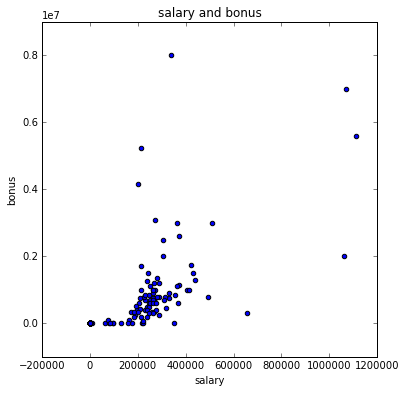

In [52]:
%matplotlib inline
### Find indices for bonus
bonus_ind = features_list.index("bonus")

### Set the size of the plot
plt.rcParams["figure.figsize"] = (6,6)

### Draw Salary histogram
plt.scatter(data[:,salary_ind], data[:,bonus_ind])
plt.xlabel("salary")
plt.ylabel("bonus")
plt.title("salary and bonus")
plt.show()

I will add colors to this scatter plot. I will color the points from poi to be red and the others to be blue.

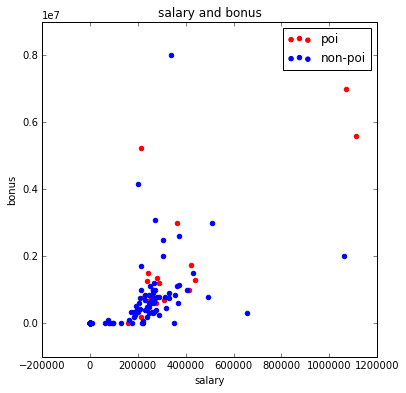

In [56]:
%matplotlib inline
### Set the size of the plot
plt.rcParams["figure.figsize"] = (6,6)

### Reassign poi index
poi_ind = features_list.index("poi")

### Create arrays for salary and bonus for poi and non-poi
salary_poi    = [data[:,salary_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
bonus_poi     = [data[:,bonus_ind][ii]  for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
salary_nonpoi = [data[:,salary_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]
bonus_nonpoi  = [data[:,bonus_ind][ii]  for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]

### Draw Salary histogram
plt.scatter(salary_poi,bonus_poi,color="r",label="poi")
plt.scatter(salary_nonpoi,bonus_nonpoi,color="b",label="non-poi")
plt.legend()
plt.xlabel("salary")
plt.ylabel("bonus")
plt.title("salary and bonus")
plt.show()



The cluster at the left bottom corner doesn't tell us much. It is difficult to identify any pattern in this cluster.

Due to the symmetry of the overall plot, I decide to apply PCA to salary and bonus after I look at more scatter plots.

Now let's use these features and see how accurately they find POI's.

In [59]:
### salary
classify_simple(['poi','salary'])

### bonus
classify_simple(['poi','bonus'])

### salary and bonus
classify_simple(['poi','salary','bonus'])

Features list: ['salary']
GaussianNB()
	Accuracy: 0.25560	Precision: 0.18481	Recall: 0.79800

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.69210	Precision: 0.23619	Recall: 0.24150

Features list: ['bonus']
GaussianNB()
	Accuracy: 0.37800	Precision: 0.22229	Recall: 0.72000

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.76233	Precision: 0.44270	Recall: 0.26850

Features list: ['salary', 'bonus']
GaussianNB()
	Accuracy: 0.24690	Precision: 0.18238	Recall: 0.79400

DecisionTreeClassifier(class_weight=None, criterion=

[[0.2469, 0.18238199150109108, 0.794], [0.6605, 0.18958611481975968, 0.213]]

Unfortunately the scores have been decreased when two features are used together.

I will try to experiment more using different parameters and using more classfiers such as SVM and KNN.

### Salary and long_term_incentive

Similar to what I did before, I will plot the scatter plot for salary and long_term_incentive.

Before plotting, I will first create a function for the scatter plot because the codes will be redundant.

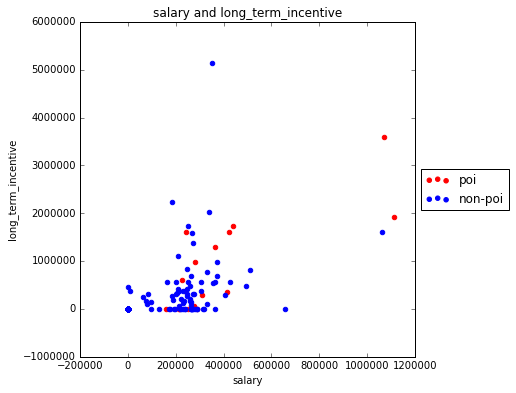

In [61]:
%matplotlib inline
### Set the size of the plot
plt.rcParams["figure.figsize"] = (6,6)

### function for scatter plots
def scatter_plotting(x,y):
    ### Find index of x and y
    x_ind = features_list.index(x)
    y_ind = features_list.index(y)
    
    ### Create arrays for salary and bonus for poi and non-poi
    x_poi    = [data[:,x_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
    y_poi    = [data[:,y_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
    x_nonpoi = [data[:,x_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]
    y_nonpoi = [data[:,y_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]

    ### Draw Salary histogram
    plt.scatter(x_poi,   y_poi,   color="r",label="poi")
    plt.scatter(x_nonpoi,y_nonpoi,color="b",label="non-poi")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("{} and {}".format(x, y))
    plt.show()
    
scatter_plotting("salary","long_term_incentive")

I will use long_term_incentive as one of features for classifier.

### More plots

From now on I will keep drawing the scatter plots until I see any interesting plot.

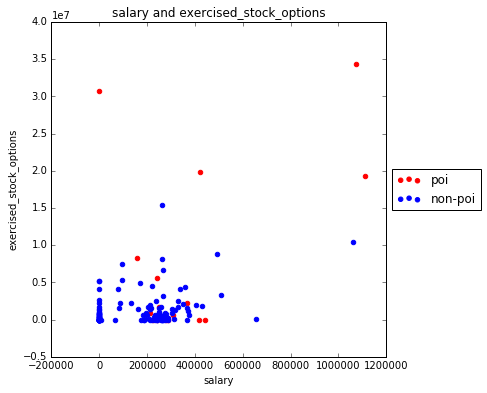

In [62]:
scatter_plotting("salary","exercised_stock_options")

There is one outlier in this plot. I will investigate this.

In [100]:
total_payments_ind = features_list.index("total_payments")
for i in data[:,total_payments_ind]:
    if i > .6e8:
        print i
        big_payment = i
for k,v in data_dict.iteritems():
    if v["total_payments"] == big_payment:
        print k, v

103559793.0
LAY KENNETH L {'salary': 1072321, 'to_messages': 4273, 'deferral_payments': 202911, 'total_payments': 103559793, 'exercised_stock_options': 34348384, 'bonus': 7000000, 'restricted_stock': 14761694, 'shared_receipt_with_poi': 2411, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 49110078, 'expenses': 99832, 'loan_advances': 81525000, 'from_messages': 36, 'other': 10359729, 'from_this_person_to_poi': 16, 'poi': True, 'director_fees': 'NaN', 'deferred_income': -300000, 'long_term_incentive': 3600000, 'email_address': 'kenneth.lay@enron.com', 'from_poi_to_this_person': 123}


Lay Kenneth L was CEO during the fall of Enron. total_payments might not be a good feature to use because most of the payments from Enron must be submitted under CEO's name so this is normal.

Let's keep digging.

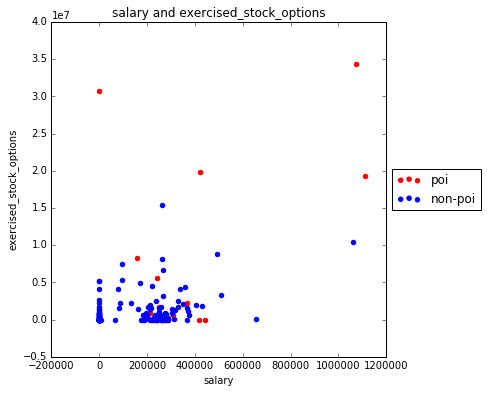

In [102]:
scatter_plotting("salary","exercised_stock_options")

Now I am getting something here. 4 of 